# Oregon Landslide Data Preprocessing

## Overview
This notebook processes landslide data from Oregon's Statewide Landslide Information Database for Oregon (SLIDO) into a standardized format for integration with other regional datasets. 

The workflow includes:

1. **Data Loading**: Load GeoDataFrame layers from SLIDO database

2. **Deposits Analysis**: Examine the main deposits layer structure and data quality

3. **References Processing**: Load and integrate citation references from the References layer. Merge reference information with landslide records using REF_ID_COD

4. **Data Standardization**: Standardize confidence levels, movement types, and material classifications

5. **Column Selection**: Select and rename columns to match unified schema

6. **Quality Assurance**: Validate data completeness and geometry integrity

7. **Export**: Save processed data as GeoJSON for further analysis

**Key Data Layers**:
- Deposits: Landslide records with detailed attributes

- References: 376 citation records linked via REF_ID_COD

Obtain the State Statewide Landslide Information Database for Oregon (SLIDO) from the official DOGAMI website: https://www.oregon.gov/dogami/slido/Pages/data.aspx 

Create a directory 'Data' in your projects root folder and place the downloaded files inside it.

# Initialization

In [1]:
import fiona
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
gdb_dir = "../Data/Oregon/SLIDO_Release_4p5_wMetadata.gdb"
layers = fiona.listlayers(gdb_dir)
print("Available layers in the GDB:")
for lyr in layers:
    df = gpd.read_file(gdb_dir, layer=lyr)
    print(f"{lyr:35s} {len(df):6d} data points")

Available layers in the GDB:
Index_LS_Studies                        72 data points


C:\Users\loicb\anaconda3\envs\landslide\Lib\site-packages\pyogrio\raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


Detailed_Deep_Landslide_Susceptibility      4 data points
References                             376 data points
Detailed_Susceptibility_Map_Index       12 data points
Historic_Landslide_Points            15386 data points
Scarp_Flanks                         28650 data points
Scarps                               55824 data points
Deposits                             71318 data points
Inventory_Map_Index                   1569 data points
Inventory_Map_Index_2                  355 data points
Inventory_Map_Index_3                  355 data points
References_Check_In_Map_Index_3         21 data points


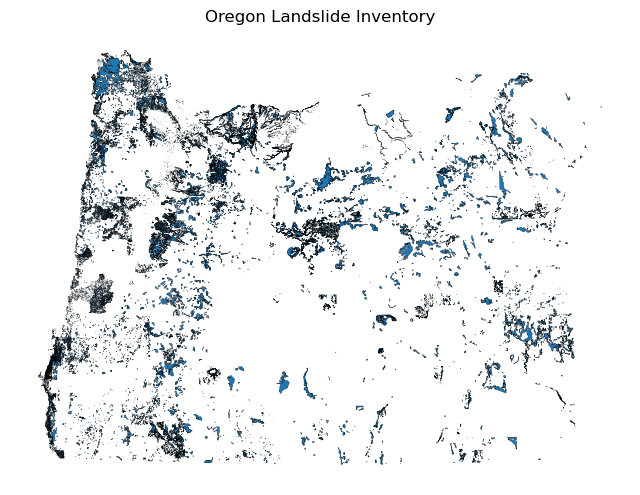

In [4]:
deposits = gpd.read_file(gdb_dir, layer="Deposits")

deposits.plot(figsize=(8, 6), edgecolor="k", linewidth=0.2)
plt.title("Oregon Landslide Inventory")
plt.axis("off")
plt.show()

# Initial Inspection

In [5]:
deposits = gpd.read_file(gdb_dir, layer="Deposits")

print("Total number of deposits:", len(deposits))

Total number of deposits: 71318


In [6]:
print(deposits.shape)
print(deposits.dtypes)

(71318, 33)
UNIQUE_ID         object
TYPE_MOVE         object
MOVE_CLASS        object
MOVE_CODE         object
CONFIDENCE        object
AGE               object
DATE_MOVE         object
NAME              object
GEOL              object
SLOPE            float32
HS_HEIGHT        float32
FAN_HEIGHT       float32
FAIL_DEPTH       float32
DEEP_SHAL         object
HS_IS1           float32
IS1_IS2          float32
IS2_IS3          float32
IS3_IS4          float32
HD_AVE           float32
DIRECT           float32
AREA             float32
VOL              float32
REF_ID_COD        object
MAP_UNIT_L        object
DESCRIPTION       object
YEAR             float64
DATE_RANGE        object
REACTIVATION      object
MONTH             object
DAY               object
Shape_Length     float64
Shape_Area       float64
geometry        geometry
dtype: object


In [7]:
import pandas as pd

def completeness(df: pd.DataFrame):
    total = len(df)
    comp = df.count()               # non-null counts per column
    pct = (comp / total * 100).round(1)
    return pd.DataFrame({"non_null": comp, "% filled": pct})


df_completeness = completeness(deposits)

In [8]:
df_completeness.sort_values(by='% filled', ascending=False)

,non_null,% filled
UNIQUE_ID,71318,100.0
REF_ID_COD,71318,100.0
Shape_Area,71318,100.0
Shape_Length,71318,100.0
DESCRIPTION,71318,100.0
geometry,71318,100.0
AREA,61271,85.9
SLOPE,60079,84.2
VOL,58717,82.3
DIRECT,58062,81.4


# New Columns

For filtering and aligning with the other cascadia datasets, we are computing some new columns. They will all start with the prefix "filter_":
* Material: [Debris, Earth, Rock, Complex, Water, Submarine]
* Mouvement: [Flow, Complex, Slide, Slide-Rotational, Slide-Translational, Avalanche, Flood, Deformation, Topple, Spread, Submarine]
* Confidence: [High, Medium, Low]
* Dataset link: URL to dataset
* Reference: Actual reference from the original data collection

the original dataset is concerved

Later in the post processing notebook, we will add more columns from external datasets

In [9]:
numerical_cols = deposits.select_dtypes(include=['number']).columns.tolist()
non_numerical_cols = deposits.select_dtypes(exclude=['number']).columns.tolist()

print("Numerical Columns:")
for col in numerical_cols:
    print(f"  - {col}")

print("\nNon-Numerical Columns:")
for col in non_numerical_cols:
    print(f"  - {col}")

Numerical Columns:
  - SLOPE
  - HS_HEIGHT
  - FAN_HEIGHT
  - FAIL_DEPTH
  - HS_IS1
  - IS1_IS2
  - IS2_IS3
  - IS3_IS4
  - HD_AVE
  - DIRECT
  - AREA
  - VOL
  - YEAR
  - Shape_Length
  - Shape_Area

Non-Numerical Columns:
  - UNIQUE_ID
  - TYPE_MOVE
  - MOVE_CLASS
  - MOVE_CODE
  - CONFIDENCE
  - AGE
  - DATE_MOVE
  - NAME
  - GEOL
  - DEEP_SHAL
  - REF_ID_COD
  - MAP_UNIT_L
  - DESCRIPTION
  - DATE_RANGE
  - REACTIVATION
  - MONTH
  - DAY
  - geometry


Out of the above columns we have to change MOVE_CLASS, MOVE_CODE, CONFIDENCE, 

## Changed Columns

### Confidence

#### Old Confidence Level


Value counts for 'CONFIDENCE':
CONFIDENCE
Moderate (11-29)     21774
High (=>30)          14541
Low (=<10)            5723
Moderate (20-30)        46
High (>30)              26
Low (<20)               10
Moderate (11-29)         5
High (=<30)              1
Moderate (15-29)         1
Name: count, dtype: int64


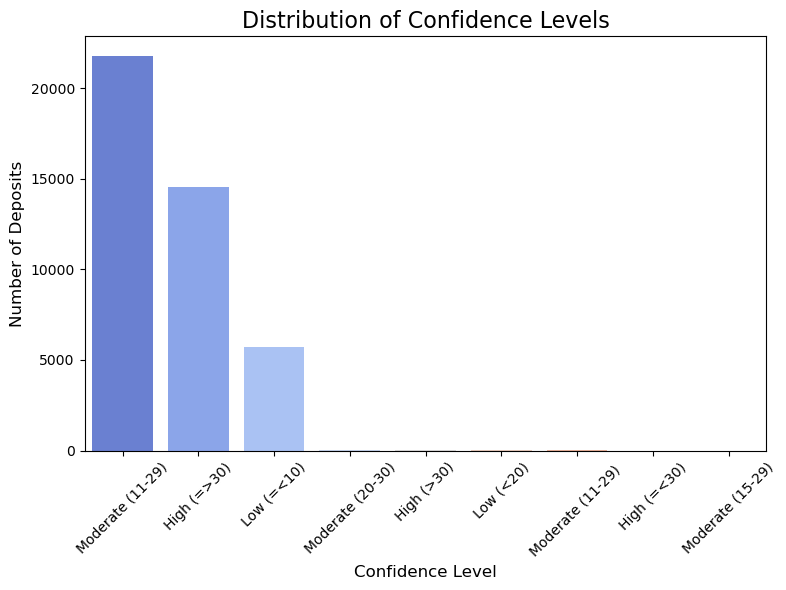

In [10]:
print("\nValue counts for 'CONFIDENCE':")
print(deposits['CONFIDENCE'].value_counts())

plt.figure(figsize=(8, 6))
confidence_counts = deposits['CONFIDENCE'].value_counts()

sns.barplot(x=confidence_counts.index, y=confidence_counts.values, palette='coolwarm', hue=confidence_counts.index)

plt.title('Distribution of Confidence Levels', fontsize=16)
plt.xlabel('Confidence Level', fontsize=12)
plt.ylabel('Number of Deposits', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here we have a lot of different confidence ranges. We only consider the major class not the ranges. So, values having low will be low and moderate will be moderate even if there is no class conflicts. 

We make this decision because there are only a few data points that fall outside the three major classes. So, we try to align this extremely small minority into major classes.

#### New Confidence Level

In [11]:
deposits['filter_CONFIDENCE'] = deposits['CONFIDENCE'].str.extract(r'^(High|Moderate|Low)')

print("Value counts for 'NEW_CONFIDENCE':")
print(deposits['filter_CONFIDENCE'].value_counts())

Value counts for 'NEW_CONFIDENCE':
filter_CONFIDENCE
Moderate    21826
High        14568
Low          5733
Name: count, dtype: int64


A quick math show that we have assigned the correct number of landslide deposits to each class.

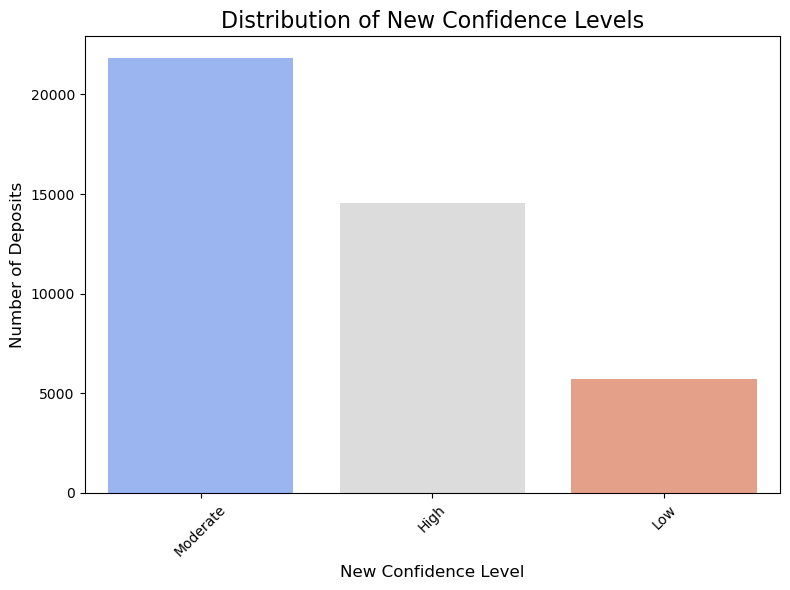

In [12]:
plt.figure(figsize=(8,6))

new_confidence_counts = deposits['filter_CONFIDENCE'].value_counts()

sns.barplot(x=new_confidence_counts.index, y=new_confidence_counts.values, palette='coolwarm', hue=new_confidence_counts.index)

plt.title('Distribution of New Confidence Levels', fontsize=16)
plt.xlabel('New Confidence Level', fontsize=12)
plt.ylabel('Number of Deposits', fontsize=12)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### MOVE CODE

In [13]:
# print("\nValue counts for 'MOVE_CODE':")
# print(deposits['MOVE_CODE'].value_counts())

print("MOVE_CODE counts (sorted by frequency):")
move_code_counts = deposits['MOVE_CODE'].value_counts()

sorted_move_codes = move_code_counts.sort_values(ascending=False)

for move_code, count in sorted_move_codes.items():
    print(f"{move_code}: {count}")
    print()  # Empty line for readability

MOVE_CODE counts (sorted by frequency):
DFL: 12752

EFL: 6919

RS-R+EFL: 4518

RS-R: 4407

RFL+EFL: 2948

RS-T: 2830

DS-T: 1800

RFL: 1665

RS-T+EFL: 798

ES-R: 777

ES-R+EFL: 736

RF: 733

ES-T: 270

ES-R + EFL: 145

DS-R: 132

RS-T+RS-R: 73

RS-R+RS-T+EFL: 68

RS-R+RS-T: 66

C: 61

RS-T+RS-R+EFL: 51

ES-R-EFL: 36

RS-T+ES-R+EFL: 34

ES-T+EFL: 29

EF: 26

RFL+RF: 25

EFL+RS-R: 19

RT+EFL: 18

RS-R+RFL: 15

RF+DS-T: 15

DS-R-DFL: 13

RFL+EF: 13

C-EFL: 12

RFL+DFL: 12

RS-T+RFL: 12

EFL+DFL: 12

C+RS-R+EFL: 11

DS-R+DFL: 11

DS-T-DFL: 9

C+RS-T+EFL: 9

RF+EF: 9

RS-R-DFL: 9

RS-R+EFL+RF: 8

RFL+RS-R: 8

EFL+RS-T: 7

RF+RS-T: 7

RS-R+DFL: 7

RFL+RS-T: 5

RS-R-EFL: 4

DS-T+DFL: 4

RS-R+ES-T+EFL: 4

RS-T+RF: 3

EFL+RF: 3

RS-R+ES-R: 3

ES-T+ES-R: 3

RS-T+RS-T: 3

DFL+EFL: 3

ES-R-DFL: 3

RF : 3

EFL+EFL: 3

RS-R+RF+EFL: 2

EFL
EFL
EFL: 2

DS-T+RS-T: 2

RS-T+EFL+RF: 2

ELF: 2

RF+EFL: 2

ES-R+EF: 2

RS-R_EFL: 2

RS-T+DFL: 2

DSP: 2

RS_T: 2

RS-R+RFL+EFL: 2

ES-R+DFL: 1

RS-R-RS-T: 1

RS-

In [14]:
deposits['MOVE_CODE'] = deposits['MOVE_CODE'].str.replace(r'\s+', '', regex=True)

# Get value counts for the cleaned codes
print("\nCleaned MOVE_CODE counts (sorted by frequency):")
clean_move_code_counts = deposits['MOVE_CODE'].value_counts()
sorted_clean_codes = clean_move_code_counts.sort_values(ascending=False)

for move_code, count in sorted_clean_codes.items():
    print(f"{move_code}: {count}")
    print()  # Empty line for readability


Cleaned MOVE_CODE counts (sorted by frequency):
DFL: 12753

EFL: 6920

RS-R+EFL: 4519

RS-R: 4408

RFL+EFL: 2948

RS-T: 2831

DS-T: 1800

RFL: 1665

ES-R+EFL: 881

RS-T+EFL: 798

ES-R: 778

RF: 736

ES-T: 270

DS-R: 132

RS-T+RS-R: 73

RS-R+RS-T+EFL: 68

RS-R+RS-T: 66

C: 61

RS-T+RS-R+EFL: 51

ES-R-EFL: 36

RS-T+ES-R+EFL: 34

ES-T+EFL: 29

EF: 26

RFL+RF: 25

EFL+RS-R: 19

RT+EFL: 18

RS-R+RFL: 15

RF+DS-T: 15

DS-R-DFL: 13

RFL+EF: 13

EFL+DFL: 12

RFL+DFL: 12

C-EFL: 12

RS-T+RFL: 12

C+RS-R+EFL: 11

DS-R+DFL: 11

RS-R-DFL: 9

RF+EF: 9

DS-T-DFL: 9

C+RS-T+EFL: 9

RS-R+EFL+RF: 8

RFL+RS-R: 8

RS-R+DFL: 7

RF+RS-T: 7

EFL+RS-T: 7

RFL+RS-T: 5

DS-T+DFL: 4

RS-R-EFL: 4

RS-R+ES-T+EFL: 4

ES-R-DFL: 3

EFL+EFL: 3

RS-T+RS-T: 3

DFL+EFL: 3

EFL+RF: 3

RS-R+ES-R: 3

RS-T+RF: 3

ES-T+ES-R: 3

ELF: 2

DS-T+RS-T: 2

RS-T+RS-R+EF: 2

RS-R+RF+EFL: 2

EFLEFLEFL: 2

RF+EFL: 2

ES-R+EF: 2

RS-T+EFL+RF: 2

RS_T: 2

RS-R+RFL+EFL: 2

RS-R_EFL: 2

RS-T+DFL: 2

DSP: 2

DS-R-EFL: 1

DS_R: 1

RS-R+RS-T

### MOVE CLASS

The original Move Class contains the kind of materials involved and the mode of movement. We seperate those into seperate columns to make it more consistent with other existing datasets.

In [15]:
print("\nValue counts for 'MOVE_CLASS':")

move_class_counts = deposits['MOVE_CLASS'].value_counts()
move_class_counts = move_class_counts.sort_values(ascending=False)
for move_class, count in move_class_counts.items():
    print(f"{move_class}: {count}")
    print()  


Value counts for 'MOVE_CLASS':
Debris Flow: 12753

Earth Flow: 7044

Complex: 6007

Rock Slide-Rotational: 5509

Rock Slide-Translational: 2445

Rock Flow: 1729

Debris Slide-Translational: 1650

Complex-Earth Slide-Rotational+Earth Flow: 826

Rock Fall: 732

Rock Slide - Translational: 511

Earth Slide - Rotational: 456

Rock Slide - Rotational: 443

Earth Slide-Rotational: 342

Complex-Rock Slide-Rotational+Earth Flow: 303

Earth Slide-Translational: 250

Rock Slide - Rotational+Earth Flow: 182

Complex-Rock Slide-rotational and Earth Flow: 171

Debris Slide - Translational: 150

Complex-Rock Slide-Translational+Earth Flow: 113

Complex Rock Slide - Translational & Earth Flow: 111

Debris Slide-Rotational: 110

Complex Rock Slide - Rotational & Earth Flow: 63

Rock Slide-Rotational+Earth Flow: 57

Combined Slump - Earth Flow: 37

Complex Earth Slide - Rotational & Earth Flow: 36

Earth Slide - Translational: 34

Rock Slide-Translational+Earth Flow: 33

Earth Fall: 25

Rock Slide - T

#### Seperate out Materials involved


Value counts for 'MATERIAL' (including nulls):
filter_MATERIAL
<NA>            28961
Debris          14719
Rock            11396
Earth            9105
Complex          6007
Earth+Rock       1110
Debris+Rock        17
Debris+Earth        2
Other               1
Name: count, dtype: int64


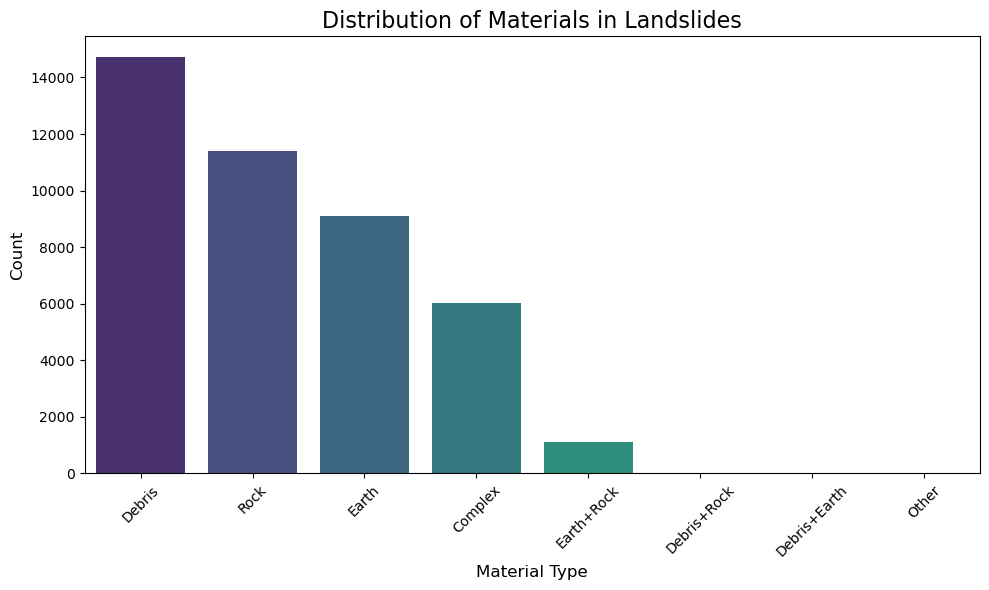

In [16]:
import re
import pandas as pd

deposits['filter_MATERIAL'] = ''

def extract_materials(move_class_str):
    # Return NaN for empty or null values instead of 'Other'
    # This is needed since a lot of the MOVE_CLASS values are empty
    if pd.isna(move_class_str) or str(move_class_str).strip() == '':
        return pd.NA
    
    move_class_str = str(move_class_str).lower()
    
    # Fix common typos 
    move_class_str = move_class_str.replace('debrs', 'debris')
    move_class_str = move_class_str.replace('rockslide', 'rock slide')
    
    materials = []
    
    # There is one Rotational Slide (slump): 1 that will be labelled as Earth
    earth_pattern = r'earth|slump'  

    # From PMags.com Talus are bigger rocks providing slightly better traction
    rock_pattern = r'rock|talus'
    
    debris_pattern = r'debr'
    
    # Check for each material type
    if re.search(earth_pattern, move_class_str, re.IGNORECASE):
        materials.append('Earth')
    if re.search(rock_pattern, move_class_str, re.IGNORECASE):
        materials.append('Rock')
    if re.search(debris_pattern, move_class_str, re.IGNORECASE):
        materials.append('Debris')
    
    # Handle special case for "Complex" without specific material
    if 'complex' in move_class_str.lower() and len(materials) == 0:
        return 'Complex'
    
    # If no materials found but the field is not empty, categorize as 'Other'
    if not materials:
        return 'Other'
    
    # Join all found materials with '+'
    # Sort to ensure consistent ordering
    return '+'.join(sorted(materials))  

# Apply the function to create a new column
deposits['filter_MATERIAL'] = deposits['MOVE_CLASS'].apply(extract_materials)

print("\nValue counts for 'MATERIAL' (including nulls):")
material_counts_final = deposits['filter_MATERIAL'].value_counts(dropna=False)
print(material_counts_final)

# Plot distribution excluding NaN values
plt.figure(figsize=(10, 6))
non_null_counts = deposits['filter_MATERIAL'].value_counts()
sns.barplot(x=non_null_counts.index, y=non_null_counts.values, 
            palette='viridis', hue=non_null_counts.index, legend=False)
plt.title('Distribution of Materials in Landslides', fontsize=16)
plt.xlabel('Material Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Seperate out Modes of Movement


Value counts for 'MOVEMENT':
filter_MOVEMENT
<NA>                                28961
Flow                                21578
Slide-Rotational                     6924
Complex                              6007
Slide-Translational                  5053
Complex+Slide-Rotational+Flow        1404
Fall                                  758
Slide-Rotational+Flow                 288
Complex+Slide-Translational+Flow      224
Slide-Translational+Flow               77
Complex+Slide+Flow                     19
Slide-Translational+Fall               16
Spread                                  3
Slide-Rotational+Spread                 1
Slide+Fall                              1
Slide-Translational+Flow+Fall           1
Slide-Rotational+Fall                   1
Complex+Flow                            1
Topple                                  1
Name: count, dtype: int64


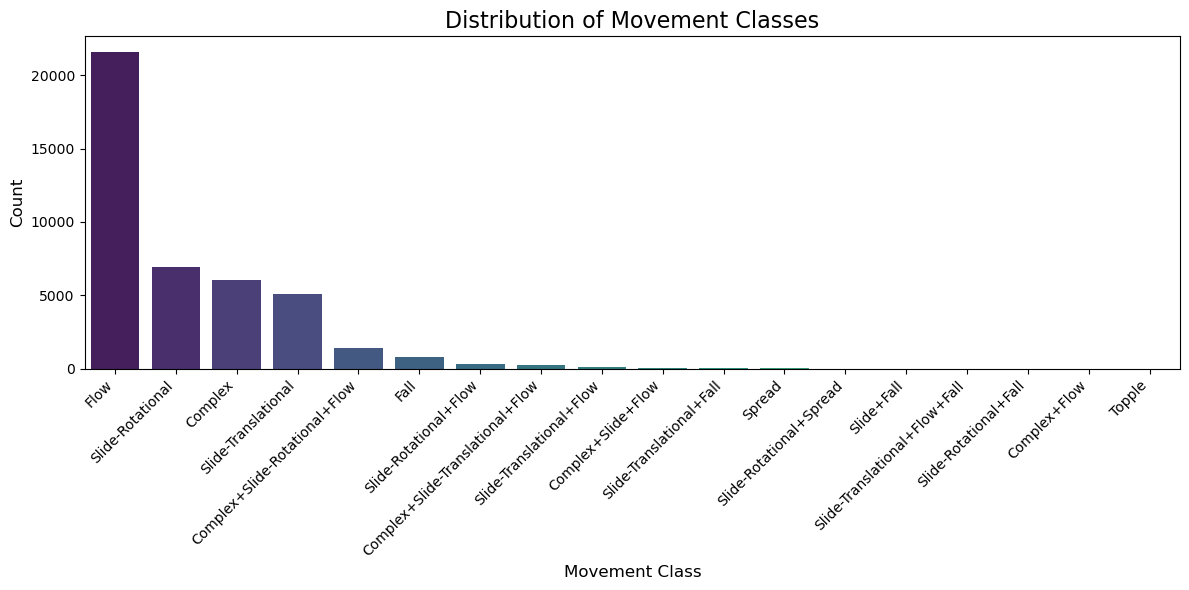

In [17]:
import re
import pandas as pd

def extract_movement_class(move_class_str):
    # Return NaN for empty or null values
    # This is needed since a lot of the MOVE_CLASS values are empty
    if pd.isna(move_class_str) or str(move_class_str).strip() == '':
        return pd.NA
    
    move_class_str = str(move_class_str).lower()
    
    # Fix some typos and standardize formatting
    move_class_str = move_class_str.replace('debrs', 'debris')
    move_class_str = move_class_str.replace('rotiational', 'rotational')
    move_class_str = move_class_str.replace('transtional', 'translational')
    move_class_str = move_class_str.replace('tanslational', 'translational')
    
    
    movement_classes = []
    
    # Check for complex first (may contain other movement types)
    if 'complex' in move_class_str:
        movement_classes.append('Complex')
    
    # Check for slide types
    if 'slide' in move_class_str:
        if 'rotational' in move_class_str or 'slump' in move_class_str:
            movement_classes.append('Slide-Rotational')
        elif 'translational' in move_class_str:
            movement_classes.append('Slide-Translational')
        else:
            movement_classes.append('Slide')
            
    # Check for flow
    if 'flow' in move_class_str:
        movement_classes.append('Flow')
        
    # Check for fall
    if 'fall' in move_class_str:
        movement_classes.append('Fall')
        
    # Check for spread
    if 'spread' in move_class_str:
        movement_classes.append('Spread')
        
    # Check for topple
    if 'topple' in move_class_str:
        movement_classes.append('Topple')
        
    # Check for avalanche
    if 'avalanche' in move_class_str:
        movement_classes.append('Avalanche')
    
    # If no movement class was identified but the string isn't empty
    if not movement_classes:
        return 'Other'
    
    # Join all identified movement classes with '+'
    return '+'.join(movement_classes)

# Apply the function to create a new column
deposits['filter_MOVEMENT'] = deposits['MOVE_CLASS'].apply(extract_movement_class)


print("\nValue counts for 'MOVEMENT':")
movement_counts = deposits['filter_MOVEMENT'].value_counts(dropna=False)
print(movement_counts)

plt.figure(figsize=(12, 6))
non_null_counts = deposits['filter_MOVEMENT'].value_counts()
sns.barplot(x=non_null_counts.index, y=non_null_counts.values, 
            palette='viridis', hue=non_null_counts.index, legend=False)
plt.title('Distribution of Movement Classes', fontsize=16)
plt.xlabel('Movement Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Check all new columns

In [18]:
print(deposits.dtypes)

UNIQUE_ID              object
TYPE_MOVE              object
MOVE_CLASS             object
MOVE_CODE              object
CONFIDENCE             object
AGE                    object
DATE_MOVE              object
NAME                   object
GEOL                   object
SLOPE                 float32
HS_HEIGHT             float32
FAN_HEIGHT            float32
FAIL_DEPTH            float32
DEEP_SHAL              object
HS_IS1                float32
IS1_IS2               float32
IS2_IS3               float32
IS3_IS4               float32
HD_AVE                float32
DIRECT                float32
AREA                  float32
VOL                   float32
REF_ID_COD             object
MAP_UNIT_L             object
DESCRIPTION            object
YEAR                  float64
DATE_RANGE             object
REACTIVATION           object
MONTH                  object
DAY                    object
Shape_Length          float64
Shape_Area            float64
geometry             geometry
filter_CON

# Create a new DataFrame

In [19]:
# Create a new GeoDataFrame
oregon_landslides = gpd.GeoDataFrame(deposits, geometry='geometry', crs=deposits.crs)

## Inspect the new DataFrame

In [20]:
# Verify the structure of the new GeoDataFrame
print("New GeoDataFrame shape:", oregon_landslides.shape)
print("\nColumn names:")
for col in oregon_landslides.columns:
    print(f"  - {col}")

# Display the first few rows to verify
oregon_landslides.head()

New GeoDataFrame shape: (71318, 36)

Column names:
  - UNIQUE_ID
  - TYPE_MOVE
  - MOVE_CLASS
  - MOVE_CODE
  - CONFIDENCE
  - AGE
  - DATE_MOVE
  - NAME
  - GEOL
  - SLOPE
  - HS_HEIGHT
  - FAN_HEIGHT
  - FAIL_DEPTH
  - DEEP_SHAL
  - HS_IS1
  - IS1_IS2
  - IS2_IS3
  - IS3_IS4
  - HD_AVE
  - DIRECT
  - AREA
  - VOL
  - REF_ID_COD
  - MAP_UNIT_L
  - DESCRIPTION
  - YEAR
  - DATE_RANGE
  - REACTIVATION
  - MONTH
  - DAY
  - Shape_Length
  - Shape_Area
  - geometry
  - filter_CONFIDENCE
  - filter_MATERIAL
  - filter_MOVEMENT


,UNIQUE_ID,TYPE_MOVE,MOVE_CLASS,MOVE_CODE,CONFIDENCE,AGE,DATE_MOVE,NAME,GEOL,SLOPE,...,DATE_RANGE,REACTIVATION,MONTH,DAY,Shape_Length,Shape_Area,geometry,filter_CONFIDENCE,filter_MATERIAL,filter_MOVEMENT
0,WASH_CO2,Flow,Debris Flow,DFL,High (=>30),Historic (<150yrs),,,vol.M.cr.gr.nd.nd.bas,4.256579,...,None,None,None,None,447.239405,11291.764767,"MULTIPOLYGON (((699810 1325184.192, 699822.282...",High,Debris,Flow
1,WASH_CO3,Flow,Debris Flow,DFL,High (=>30),Historic (<150yrs),,,vol.M.cr.gr.nd.nd.bas,3.350513,...,None,None,None,None,455.775817,13701.014637,"MULTIPOLYGON (((699860.473 1325401.027, 699873...",High,Debris,Flow
2,WASH_CO4,Flow,Debris Flow,DFL,High (=>30),Historic (<150yrs),,,vol.M.cr.gr.nd.nd.bas,5.811321,...,None,None,None,None,568.959463,14879.315815,"MULTIPOLYGON (((700295.984 1325083.866, 700283...",High,Debris,Flow
3,WASH_CO5,Flow,Debris Flow,DFL,High (=>30),Historic (<150yrs),,,sed.Q.qsd.mf.nd.nd.fine,5.413578,...,None,None,None,None,591.097110,20034.804942,"MULTIPOLYGON (((700696.889 1325351.537, 700659...",High,Debris,Flow
4,WASH_CO6,Flow,Debris Flow,DFL,High (=>30),Historic (<150yrs),,,vol.M.cr.gr.nd.nd.bas,13.638928,...,None,None,None,None,391.627031,8462.716893,"MULTIPOLYGON (((699242.636 1321687.547, 699279...",High,Debris,Flow


### Inspect References inside Deposits Layer

In [21]:
print("Inspecting references in oregon_landslides:")
print(f"Total records: {len(oregon_landslides)}")
print(f"Records with REF_ID_COD: {oregon_landslides['REF_ID_COD'].notna().sum()}")
print(f"Records without REF_ID_COD: {oregon_landslides['REF_ID_COD'].isna().sum()}")

print("\nTop 10 most common references:")
ref_counts = oregon_landslides['REF_ID_COD'].value_counts().head(10)
for ref_id, count in ref_counts.items():
    print(f"{ref_id}: {count}")

print(f"\nTotal unique references: {oregon_landslides['REF_ID_COD'].nunique()}")

print("\nSample of reference IDs:")
sample_refs = oregon_landslides['REF_ID_COD'].dropna().unique()[:10]
for ref in sample_refs:
    print(f"  - {ref}")

Inspecting references in oregon_landslides:
Total records: 71318
Records with REF_ID_COD: 71318
Records without REF_ID_COD: 0

Top 10 most common references:
HairRW2021: 5017
CalhNC2020a: 4096
BurnWJ2017a: 2986
BurnWJ2012a: 2837
BurnWJ2023: 2693
BurnWJ2014: 2483
BurnWJ2021: 2228
McClJD2021b: 2122
CALHNC2020: 2098
BurnWJ2018: 1969

Total unique references: 346

Sample of reference IDs:
  - HairRW2021
  - BurnWJ2023
  - BurnWJ2010a
  - BurnWJ2010b
  - BurnWJ2010c
  - BurnWJ2009b
  - BurnWJ2010d
  - MertSA2007a
  - McClJD2010
  - HladFR2007


## Inspect References Layer

In [22]:
# Load and inspect the References layer
references = gpd.read_file(gdb_dir, layer="References")

print("References layer shape:", references.shape)
print("\nReferences layer columns:")
for col in references.columns:
    print(f"  - {col}")

print("\nFirst few rows of References:")
print(references.head())

print("\nData types:")
print(references.dtypes)

# Check for common reference identifiers between deposits and references
print("\nUnique REF_ID_COD values in deposits (first 10):")
print(deposits['REF_ID_COD'].unique()[:10])

print("\nUnique REF_ID_COD values in references:")
print(references['REF_ID_COD'].unique())

# Check if there's overlap
common_refs = set(deposits['REF_ID_COD'].dropna()) & set(references['REF_ID_COD'].dropna())
print(f"\nNumber of common reference IDs: {len(common_refs)}")
print("Sample common reference IDs:", list(common_refs)[:5])

References layer shape: (376, 4)

References layer columns:
  - REF_ID_COD
  - SCALE
  - REFERENCE
  - DATE

First few rows of References:
   REF_ID_COD     SCALE                                          REFERENCE  \
0   AchJA1991  1:24,000  Ach, J.A., Bateson, J.T., 1991, Geologic map o...   
1  AllaJC2001  1:25,000  Allan, J.C.; Priest, G.R., 2001, Evaluation of...   
2  AlleJE1988  1:24,000  Allen, J.E., 1988, Geologic Hazards in the Col...   
3  AndeJL1978  1:24,000  Anderson, J. L., 1978, The stratigraphy and st...   
4  AshlRP1966  1:21,100  Ashley, R.P., 1966, Metamorphic petrology and ...   

   DATE  
0  1991  
1  2001  
2  1988  
3  1978  
4  1966  

Data types:
REF_ID_COD    object
SCALE         object
REFERENCE     object
DATE          object
dtype: object

Unique REF_ID_COD values in deposits (first 10):
['HairRW2021' 'BurnWJ2023' 'BurnWJ2010a' 'BurnWJ2010b' 'BurnWJ2010c'
 'BurnWJ2009b' 'BurnWJ2010d' 'MertSA2007a' 'McClJD2010' 'HladFR2007']

Unique REF_ID_COD values in ref

In [23]:
# Merge the references information into oregon_landslides
oregon_landslides = oregon_landslides.merge(
    references[['REF_ID_COD', 'REFERENCE']], 
    on='REF_ID_COD', 
    how='left'
)

print("Successfully added REFERENCE column to oregon_landslides")
print(f"Records with references: {oregon_landslides['REFERENCE'].notna().sum()}")
print(f"Records without references: {oregon_landslides['REFERENCE'].isna().sum()}")

# Display a sample of the new column
print("\nSample references:")
sample_refs = oregon_landslides[oregon_landslides['REFERENCE'].notna()]['REFERENCE'].head(3)
for i, ref in enumerate(sample_refs):
    print(f"{i+1}. {ref[:100]}...")

Successfully added REFERENCE column to oregon_landslides
Records with references: 69220
Records without references: 2098

Sample references:
1. Hairston-Porter, R., Madin, I., Burns, W., and Appleby, C., 2021, Landslide, coseismic liquefaction ...
2. Hairston-Porter, R., Madin, I., Burns, W., and Appleby, C., 2021, Landslide, coseismic liquefaction ...
3. Hairston-Porter, R., Madin, I., Burns, W., and Appleby, C., 2021, Landslide, coseismic liquefaction ...


In [24]:
print("Columns in oregon_landslides:")
for i, col in enumerate(oregon_landslides.columns):
    print(f"{i+1:2d}. {col}")

Columns in oregon_landslides:
 1. UNIQUE_ID
 2. TYPE_MOVE
 3. MOVE_CLASS
 4. MOVE_CODE
 5. CONFIDENCE
 6. AGE
 7. DATE_MOVE
 8. NAME
 9. GEOL
10. SLOPE
11. HS_HEIGHT
12. FAN_HEIGHT
13. FAIL_DEPTH
14. DEEP_SHAL
15. HS_IS1
16. IS1_IS2
17. IS2_IS3
18. IS3_IS4
19. HD_AVE
20. DIRECT
21. AREA
22. VOL
23. REF_ID_COD
24. MAP_UNIT_L
25. DESCRIPTION
26. YEAR
27. DATE_RANGE
28. REACTIVATION
29. MONTH
30. DAY
31. Shape_Length
32. Shape_Area
33. geometry
34. filter_CONFIDENCE
35. filter_MATERIAL
36. filter_MOVEMENT
37. REFERENCE


In [29]:
oregon_landslides['filter_DATASET_LINK'] = 'https://www.oregon.gov/dogami/slido/Pages/data.aspx'

In [30]:
oregon_landslides['filter_ORIGIN'] = 'OR'

In [31]:
oregon_landslides = oregon_landslides.rename(columns={'REFERENCE': 'filter_REFERENCE'})

## Save into GeoJSON

In [32]:
oregon_landslides.to_file("./processed_geojson/oregon_landslides_processed.geojson", driver="GeoJSON")

In [33]:
# oregon_landslides.to_file("oregon_landslides_processed.shp")

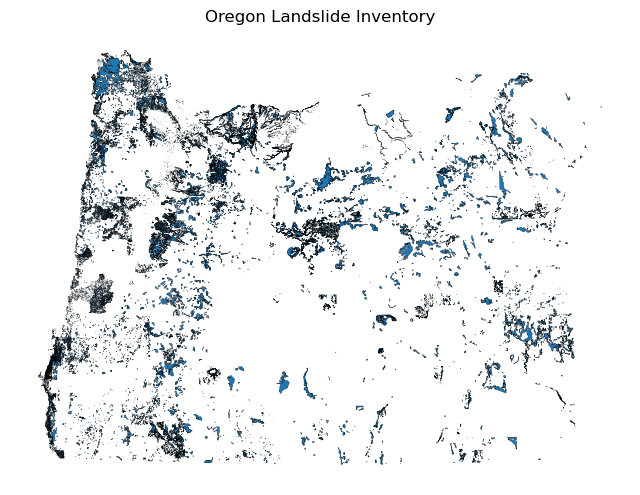

In [34]:
oregon_landslides.plot(figsize=(8, 6), edgecolor="k", linewidth=0.2)
plt.title("Oregon Landslide Inventory")
plt.axis("off")
plt.show()

In [35]:
oregon_landslides.columns

Index(['UNIQUE_ID', 'TYPE_MOVE', 'MOVE_CLASS', 'MOVE_CODE', 'CONFIDENCE',
       'AGE', 'DATE_MOVE', 'NAME', 'GEOL', 'SLOPE', 'HS_HEIGHT', 'FAN_HEIGHT',
       'FAIL_DEPTH', 'DEEP_SHAL', 'HS_IS1', 'IS1_IS2', 'IS2_IS3', 'IS3_IS4',
       'HD_AVE', 'DIRECT', 'AREA', 'VOL', 'REF_ID_COD', 'MAP_UNIT_L',
       'DESCRIPTION', 'YEAR', 'DATE_RANGE', 'REACTIVATION', 'MONTH', 'DAY',
       'Shape_Length', 'Shape_Area', 'geometry', 'filter_CONFIDENCE',
       'filter_MATERIAL', 'filter_MOVEMENT', 'filter_REFERENCE',
       'filter_DATASET_LINK', 'filter_ORIGIN'],
      dtype='object')